In [2]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from lib import evaluate
from lib.serialize import iter_jl
import pandas as pd


In [80]:
%reload_ext autoreload
%autoreload 2

In [6]:
dict_genres = {'pop': 1, 'country': 2, 'blues': 3, 'rock': 4, 'jazz': 5, "reggae": 6, "hip hop": 7}

In [7]:
df = pd.read_csv('tcc_ceds_music.csv')

In [8]:
df['genre'] = df['genre'].apply(lambda x: dict_genres[x])

In [119]:
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,1,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,1,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,1,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,1,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,1,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


In [9]:
train, test = evaluate.date_split(df)

In [10]:
X_train, y_train = evaluate.x_y_split(train)
X_test, y_test = evaluate.x_y_split(test)

In [11]:
evaluate.to_json_lines(X_train,y_train,'train')
evaluate.to_json_lines(X_test,y_test,'test')

In [12]:
X_train, y_train = iter_jl('X_train.jl'), iter_jl('y_train.jl')

In [13]:
X_test, y_test = iter_jl('X_test.jl'), iter_jl('y_test.jl')

In [14]:
X_train = list(X_train)
y_train = list(y_train)
X_test = list(X_test)
y_test = list(y_test)

In [403]:
from lib.transformers import FeatureProjectionFromJson, TargetEncoder, PretrainedFastTextTransformer, TargetEncodeWithNumerical
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

fields = ['age','violence','world/life','night/time', 'shake the audience',
                            'family/gospel','romantic','communication','obscene','music','movement/places',
                           'light/visual perceptions','family/spiritual','sadness',
                           'danceability','loudness','acousticness','instrumentalness','valence','energy'] 
#saque algunos numericos: 'dating','like/girls','feelings',

features_pipe = make_union(make_pipeline(
        FeatureProjectionFromJson(fields)
    ,SimpleImputer()
),
                          make_pipeline(TargetEncodeWithNumerical('topic', fields)),
                           make_pipeline(TargetEncodeWithNumerical('artist_name', fields))
                          )

In [404]:
import lightgbm as lgb

In [405]:
rf_pipe = make_pipeline(
    features_pipe,
    lgb.LGBMClassifier(n_estimators =  100, random_state=42, class_weight = 'balanced')
)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featureprojectionfromjson',
                                                                  FeatureProjectionFromJson(fields=['age',
                                                                                                    'world/life',
                                                                                                    'night/time',
                                                                                                    'shake '
                                                                                                    'the '
                                                                                                    'audience',
                                                                                                    'family/gospel',
                                                                                                    'romantic',
                                                                                                    'communication',
                                                                                                    'obscene',
                                                                                                    'music',
                                                                                                    'movement/places',
                                                                                                    'light/visual '
                                                                                                    'perceptions',
                                                                                                    'family/spiritual',
                                                                                                    'sadness',
                                                                                                    'da...
                                                                                            numerical_fields=['age',
                                                                                                              'world/life',
                                                                                                              'night/time',
                                                                                                              'shake '
                                                                                                              'the '
                                                                                                              'audience',
                                                                                                              'family/gospel',
                                                                                                              'romantic',
                                                                                                              'communication',
                                                                                                              'obscene',
                                                                                                              'music',
                                                                                                              'movement/places',
                                                                                                              'light/visual '
                                                                                                              'perceptions',
                                                                                                              'family/spiritual',
                                           

In [406]:
#rf_pipe.steps[0][1].transformer_list[1][1].steps[0][1].stats_

In [407]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics_multi(y_true, y_pred):
    dicc = {'f1': f1_score(y_true, y_pred, average = 'macro'),
      'precision': precision_score(y_true, y_pred, average = 'macro'),
      'acc': accuracy_score(y_true, y_pred),
      'recall': recall_score(y_true, y_pred, average = 'macro')}
    print(dicc)
    return(dicc)

In [408]:
get_metrics_multi(y_train,rf_pipe.predict(X_train))

{'f1': 0.9272511489234264, 'precision': 0.9134412404263171, 'acc': 0.9247845490920283, 'recall': 0.9440086061657558}


{'f1': 0.9272511489234264,
 'precision': 0.9134412404263171,
 'acc': 0.9247845490920283,
 'recall': 0.9440086061657558}

In [409]:
preds = rf_pipe.predict(X_test)

In [410]:
get_metrics_multi(y_test,preds)

{'f1': 0.6455594918928618, 'precision': 0.6664258702281327, 'acc': 0.6470588235294118, 'recall': 0.6456471128966211}


{'f1': 0.6455594918928618,
 'precision': 0.6664258702281327,
 'acc': 0.6470588235294118,
 'recall': 0.6456471128966211}

In [393]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pylab as plt

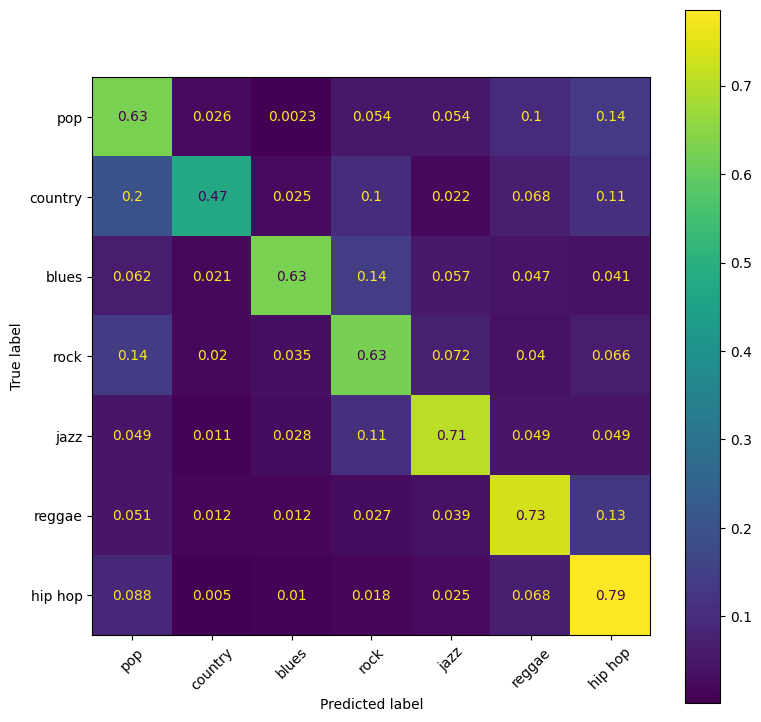

In [394]:
fig, ax  = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='true', ax=ax)
ax.xaxis.set_ticklabels(list(dict_genres.keys()))
ax.yaxis.set_ticklabels(list(dict_genres.keys()))
ax.xaxis.set_tick_params(rotation=45)